### Predicción de ETo con un dataset generado calculando ETo manualmente

In [10]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, LSTM, Bidirectional, Attention, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv('custom_weather_data.csv', index_col=['Date'], parse_dates=True) # Necesario parse_dates para que el indice sea tipo datetime
df.head()

,Solar Radiation (W/m²),Heat Flux Density (W/m²),Mean Temperature (°C),Vapor Pressure Slope (kPa/ºC),Wind Speed (m/s),T_min,T_max
Date,,,,,,,
2023-01-01,384.987706,228.234406,25.320376,0.952271,9.276121,21.204441,27.827692
2023-01-02,435.759804,278.652402,26.446891,1.004507,6.206753,19.667378,28.572243
2023-01-03,443.778788,260.028145,28.814782,1.049978,5.695680,27.047165,35.596402
2023-01-04,396.162356,247.336488,21.838875,0.851710,3.409369,20.112822,26.648638
2023-01-05,408.274535,243.737733,26.264700,0.987383,2.279993,20.979772,31.902069


#### Paso 1: Calcular la ETo usando la fórmula de Penman-Monteith

In [12]:
# Constante psicrométrica (kPa/ºC)
gamma = 0.665

# Parámetros necesarios
T = df['Mean Temperature (°C)']
Rn = df['Solar Radiation (W/m²)'] * 0.0864
u2 = df['Wind Speed (m/s)']
Delta = df['Vapor Pressure Slope (kPa/ºC)']

# Presión de vapor de saturación (kPa)
e_s = 0.6108 * np.exp((17.27 * T) / (T + 237.3))

# Presión actual (suponemos el 70% para simplificar)
e_a = e_s * 0.7

# Flujo de calor del suelo
G = 0

# Aplicar fçormula Penman-Monteith
ETo = (0.408 * Delta * (Rn - G) + gamma * (900 / (T + 273)) * u2 * (e_s - e_a)) / (Delta + gamma * (1 + 0.34 * u2))

# Añadir la columna ETo al dataframe
df['ETo (mm/dia)'] = ETo

In [13]:
df

,Solar Radiation (W/m²),Heat Flux Density (W/m²),Mean Temperature (°C),Vapor Pressure Slope (kPa/ºC),Wind Speed (m/s),T_min,T_max,ETo (mm/dia)
Date,,,,,,,,
2023-01-01,384.987706,228.234406,25.320376,0.952271,9.276121,21.204441,27.827692,8.331878
2023-01-02,435.759804,278.652402,26.446891,1.004507,6.206753,19.667378,28.572243,9.201396
2023-01-03,443.778788,260.028145,28.814782,1.049978,5.695680,27.047165,35.596402,9.942043
2023-01-04,396.162356,247.336488,21.838875,0.851710,3.409369,20.112822,26.648638,7.575739
2023-01-05,408.274535,243.737733,26.264700,0.987383,2.279993,20.979772,31.902069,8.709499
...,...,...,...,...,...,...,...,...
2025-09-22,400.212834,241.387236,23.614501,0.901570,5.793780,21.672403,30.465031,7.976477
2025-09-23,354.462393,206.505274,23.263684,0.891987,6.971197,19.406041,26.051675,7.406463
2025-09-24,378.712282,232.502462,26.524220,0.995561,7.957566,19.547760,32.999992,8.621705


#### Paso 2: Preprocesado de datos

In [14]:
# Asegurar reproducibilidad
tf.random.set_seed(27)

In [15]:
def secuencias(df, features, target, lookback):
    X, y = [], []
    for i in range(len(df) - lookback):
        X.append(df[features].iloc[i:i+lookback].values) # Recoge los features dejando fueras los n señalados como lookback
        y.append(df[target].iloc[i+lookback]) # Para cada paso temporal guarda n lookback como target
    return np.array(X), np.array(y)

In [16]:
# Establecer la longitud de los datos para entrenamiento
train_size = int(len(df) * 0.7)
train, test = df[:train_size], df[train_size:]

# Establecer features y target
features = ['Solar Radiation (W/m²)', 
            'Heat Flux Density (W/m²)',
            'Mean Temperature (°C)',
            'Vapor Pressure Slope (kPa/ºC)',
            'Wind Speed (m/s)',
            'T_min', 'T_max']
target = 'ETo (mm/dia)'

# Estandarizar datos
scaler = StandardScaler()
train[features] = scaler.fit_transform(train[features])
test[features] = scaler.transform(test[features])

# Crear los conjuntos separados X e y para entrenamiento y validación
X_train, y_train = secuencias(train, features, target, lookback=3)
X_test, y_test = secuencias(test, features, target, lookback=3)

In [17]:
print('Forma del dataset de entrenamiento')
print(f'Filas: {X_train.shape[0]}\t Pasos temporales: {X_train.shape[1]}\t Atributos: {X_train.shape[2]}')

Forma del dataset de entrenamiento
Filas: 697	 Pasos temporales: 3	 Atributos: 7


#### Paso 3: Creación del modelo

In [18]:
# Capa de entrada, recibe pasos temporales y atributos
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# Capa bidireccional LSTM, con retorno de secuencias
lstm1 = Bidirectional(LSTM(512, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))(input_layer)
lstm2 = LSTM(256, return_sequences=True, dropout=0.3)(lstm1)
lstm3 = LSTM(128, return_sequences=True, dropout=0.3)(lstm2)

# Capa atencional. Recibe dos valores (query y key-value) con shape: batch_size, time_steps, features
# Calcula los pesos entre el query y las keys para ponderar los values
att = Attention()([lstm3, lstm3])

# Context vector, representación numérica de la secuencia tras la capa de atención
ctx_vector = Flatten()(att)

# Capas densas
x = Dense(128, activation='relu')(ctx_vector)
x = Dropout(0.3)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(16, activation='relu')(x)
x = Dropout(0.3)(x)
output_layer = Dense(1, activation='linear')(x)

# Construir y compilar
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3, 7)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 3, 1024)   │  2,129,920 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 3, 256)    │  1,311,744 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 3, 128)    │    197,120 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 3, 128)    │          0 │ lstm_2[0][0],     │
│ (Attention)         │                   │            │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 384)       │          0 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     49,280 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      2,080 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 32)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │        528 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 16)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │         17 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,698,945 (14.11 MB)

 Trainable params: 3,698,945 (14.11 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Crear un early stopper
early_stop = EarlyStopping(
    monitor='val_loss', # Pérdida en validación como referencia
    patience=10, # Detiene el entrenamiento si no hay mejoras tras 7 rondas
    restore_best_weights=True # Recupera los mejores pesos obtenidos
)

In [20]:
history = model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          epochs=50,
          batch_size=16,
          callbacks=[early_stop])

Epoch 1/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 64ms/step - loss: 60.3313 - mae: 6.8486 - val_loss: 5.1855 - val_mae: 1.6052
Epoch 2/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 18.9662 - mae: 3.4216 - val_loss: 4.2488 - val_mae: 1.6055
Epoch 3/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 17.5799 - mae: 3.2681 - val_loss: 3.5303 - val_mae: 1.4810
Epoch 4/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 15.8549 - mae: 3.1105 - val_loss: 4.1194 - val_mae: 1.7078
Epoch 5/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 12.6412 - mae: 2.7829 - val_loss: 3.6265 - val_mae: 1.5277
Epoch 6/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 12.8121 - mae: 2.7824 - val_loss: 7.3357 - val_mae: 2.1373
Epoch 7/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 12.3810 - mae: 2.7245 - val_loss: 2.3996 - val_mae: 1.1958
Epoch 8/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 11.7396 - mae: 2.5404 - val_loss: 4.3610 - val_mae: 1.7248
Epoch 9/50
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - los

In [21]:
valid_error = model.evaluate(X_test, y_test)

print(f'Mean Squared Error: {valid_error[0]:.2f}')
print(f'Mean Absolute Error: {valid_error[1]:.2f}')

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3778 - mae: 0.8999
Mean Squared Error: 1.52
Mean Absolute Error: 0.94


#### Paso 4: Visualización de resultados

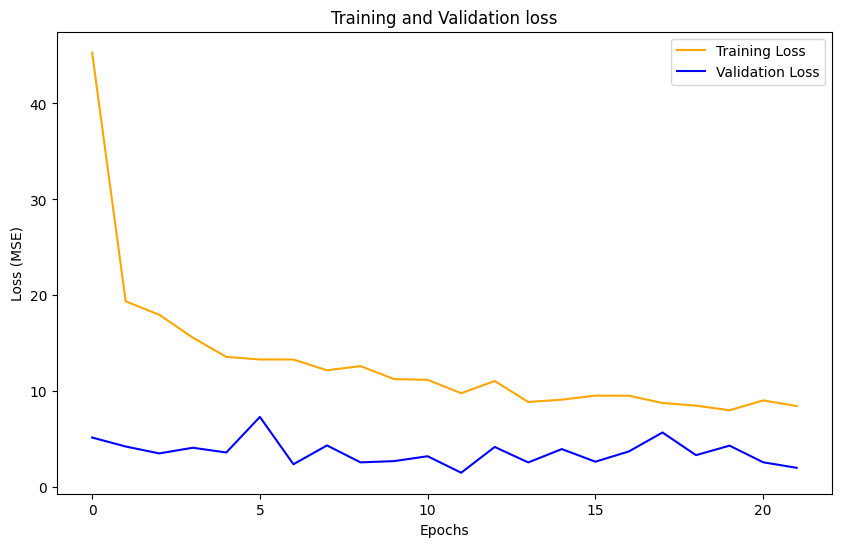

In [22]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')

plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')

plt.legend()
plt.show()

In [23]:
y_pred = model.predict(X_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


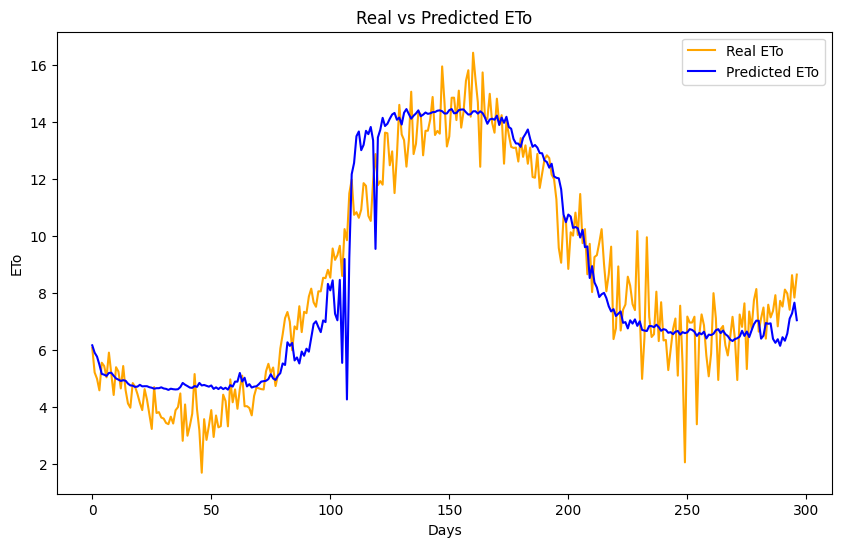

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Real ETo', color='orange')
plt.plot(y_pred, label='Predicted ETo', color='blue')

plt.title('Real vs Predicted ETo')
plt.xlabel('Days')
plt.ylabel('ETo')
plt.legend()
plt.show()